# Learning Based Image Super-resolution

LS2N-SIMS - Ecole Centrale Nantes

Supervisor: **Diana Mateus**

Student: **Wenrui Li**

### Introduction

In this notebook we will model the image super-resolution (SR) problem and approache it by means of deep learning, and more specifically with the U-Net architecture.

### 0. Prepare the kernel


#### 0.1 Create a virtual environment to run this code if you want to avoid interference with other configurations and versions

__With virtualenv__

`` install virtualenv``

``create the virtualenv``

``virtualenv myenv``

``activate the virtualenv``

``source myenv/bin/activate``

__With anaconda__

https://conda.io/docs/user-guide/tasks/manage-environments.html

#### 0.2 Install all the required modules

If not installed, install the following modules
- pip install pandas
- pip install scikit-image
- pip install tensorflow
- pip install keras
- pip install tqdm
- pip install sklearn

#### 0.3 Running jupyter notebook with the activated environment

link the notebook to the created virtual-env kernel

pip install ipykernel
ipython kernel install --user --name=projectname

### 1. Load modules and data

#### 1.1 Import modules

In [1]:
#4S
# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying 

#Keras and related modules
import keras
from keras import backend as K                        #https://keras.io/backend/
import tensorflow as tf

#Layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Lambda                       #Lambda wraps arbitrary expression as a Layer object.
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import add, concatenate
from keras import regularizers
from keras.initializers import he_normal, glorot_normal, RandomNormal

#To save and reload models, to modify model parameters by callbacks
from keras.models import load_model, Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LearningRateScheduler
from keras.utils import multi_gpu_model, plot_model

#For data augmentation
from keras.preprocessing.image import ImageDataGenerator    

#Sklearn 
import sklearn
from sklearn.model_selection import train_test_split

#Scipy
#import scipy.misc

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', tf.__version__)
#print('Scipy        :', scipy.__version__)

Using TensorFlow backend.


Python       : 3.5.6 |Anaconda, Inc.| (default, Aug 26 2018, 16:05:27) [MSC v.1900 64 bit (AMD64)]
Numpy        : 1.15.2
Skimage      : 0.14.2
Scikit-learn : 0.20.0
Keras        : 2.2.4
Tensorflow   : 1.12.0


#### 1.2 Define global parameters
- Set seed for random values to a fix number (42) to ensure that we get images and labels that correspond to each other. 
- Define the SR factor
- Define the input image size``` img_height, img_width ```
- Define the stride for cutting input images from original images
- Define the number of color channels, 1 for gray images and Y channel images, 3 for RGB images

In [2]:
#4S
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

# Set number of GPUs
num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set the SR factor, usually 2, 3 or 4
SR_factor = 3

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (192,192) if SR_factor == 3 else (256,256)

# Set stride for cutting images
cut_stride = img_height

# Set number of color channels
chan_num = 1

#### 1.3 Import data 

#### 1.3.1 Define the data path
Define the data path and change the directory to the defined topDir. Also specify the train and test directories

In [4]:
#4S
topDir = "." 
os.chdir(topDir)    
print(os.listdir(os.path.join(topDir, 'input')))  #see what's in the input folder (where data is in)
train_path = os.path.join(topDir, 'input/train/T91')  #path to training data file/folder
test_path = os.path.join(topDir, 'input/test/Set5')   #path to test data file/folder
valid_path = os.path.join(topDir, 'input/test/Set14')  #path to validation data file/folder

['test', 'train']


#### 1.3.2 Read and preload the HR image data
Read the data and create a tensor containing all the ground truth images (HR images).

Create a function ``get_HR_images`` that 
- receives as input an image path (can be train, validation or test).
- lists all files in the input image path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread`` or ``skimage.io.ImageCollection``
- use only the first three channels of the images
- transfer RGB to YCbCr, store them respectively and return them as numpy arrays.
- cut images into predefined size ``(img_height, img_width)`` with predefined stride ``cut_stride``.
- use ``%%time`` to display the time spent in loading.
- Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 or float64

In [5]:
def modcrop(image, scale=SR_factor):
    if len(image.shape) == 3: # 3 channel image
        h, w, _ = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w, :]
    else:  # 1 channel image
        h, w = image.shape
        h = h - np.mod(h, scale)
        w = w - np.mod(w, scale)
        image = image[0:h, 0:w]
    return image

In [6]:
%%time
# Get HR data
def get_HR_images(path):
    
    HR_img = []
    HR_cb = []
    HR_cr = []
    
    #Loads images from path/{id}.jpg into a numpy array
    files_list = os.listdir(path)
    files_list.sort(key = lambda x:x[:-4])
    img_paths = ['{0}/{1}'.format(path, id) for id in files_list]
    
    ic = skimage.io.ImageCollection(load_pattern=img_paths)
    
    for im in ic:
        im = modcrop(im, SR_factor)
        im = skimage.color.rgb2ycbcr(im)
        cb = im[:,:,1]
        cr = im[:,:,2]
        im = im[:,:,0] # super-resolve Y channel only
                
        (h,w) = im.shape
        for x in range(0,h-img_height+1,cut_stride):
                    for y in range(0,w-img_width+1,cut_stride):
                                im_full = im[x : x+img_height, y : y+img_width]
                                HR_img.append(im_full)
                                cb_full = cb[x : x+img_height, y : y+img_width]
                                HR_cb.append(cb_full)
                                cr_full = cr[x : x+img_height, y : y+img_width]
                                HR_cr.append(cr_full)
    
    HR_img = np.array(HR_img)
    HR_img = HR_img.reshape(HR_img.shape[0],HR_img.shape[1],HR_img.shape[2],chan_num)
    
    HR_cb = np.array(HR_cb)
    HR_cb = HR_cb.reshape(HR_cb.shape[0],HR_cb.shape[1],HR_cb.shape[2],chan_num)
    
    HR_cr = np.array(HR_cr)
    HR_cr = HR_cr.reshape(HR_cr.shape[0],HR_cr.shape[1],HR_cr.shape[2],chan_num)
    
    return HR_img, HR_cb, HR_cr

HR_train, HR_train_cb, HR_train_cr = get_HR_images(train_path)
print('HR training images:', HR_train.shape, HR_train.dtype)

HR_test, HR_test_cb, HR_test_cr = get_HR_images(test_path)
print('HR test images:', HR_test.shape, HR_test.dtype)

HR_valid, HR_valid_cb, HR_valid_cr = get_HR_images(valid_path)
print('HR validation images:', HR_valid.shape, HR_valid.dtype)

HR training images: (54, 192, 192, 1) float64
HR test images: (8, 192, 192, 1) float64
HR validation images: (51, 192, 192, 1) float64
Wall time: 2.63 s


#### 1.3.3 Process the HR image data to acquire LR images (network inputs)
Create a tensor containing all the input images (LR images).

Create a function ``get_LR_images`` that
- receives as input a HR image array (can be train or test)
- downsample the images with bicubic interpolation. 
- implement bicubic interpolation to upscale the LR image to the size of the HR ones.
- return a numpy array (matrix) .
- use ``%%time`` to display the time spent in loading.
- Run the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 or float64

In [7]:
%%time
# Get LR data
def get_LR_images(HR_data):
    
    LR_img = []
    
    for i in range(HR_data.shape[0]):
        im_i = HR_data[i,:,:,:] # Acquire one image
        
        # downsampling, order = 3 -> bicubic, anti_aliasing = True -> implement Gaussian blurring
        downsampled_i = skimage.transform.rescale(im_i, scale=1/SR_factor, order=3, mode='reflect', cval=0, clip=True, 
                                preserve_range=False, multichannel=True, anti_aliasing=True, anti_aliasing_sigma=None)
        
        #bicubic interpolation
        interpolated_i = skimage.transform.rescale(downsampled_i, scale=SR_factor, order=3, mode='reflect', cval=0, clip=True, 
                                preserve_range=False, multichannel=True, anti_aliasing=True, anti_aliasing_sigma=None)
        
        LR_img.append(interpolated_i)

    LR_img = np.array(LR_img)
    LR_img = LR_img.reshape(LR_img.shape[0],LR_img.shape[1],LR_img.shape[2],chan_num)
    return LR_img

LR_train = get_LR_images(HR_train)
print('LR training images:', LR_train.shape, LR_train.dtype)

LR_test = get_LR_images(HR_test)
print('LR test images:', LR_test.shape, LR_test.dtype)

LR_valid = get_LR_images(HR_valid)
print('LR valid images:', LR_valid.shape, LR_valid.dtype)

LR_test_cb = get_LR_images(HR_test_cb)
print('LR test cb channel:', LR_test_cb.shape, LR_test_cb.dtype)

LR_test_cr = get_LR_images(HR_test_cr)
print('LR test cr channel:', LR_test_cr.shape, LR_test_cr.dtype)


LR training images: (54, 192, 192, 1) float64
LR test images: (8, 192, 192, 1) float64
LR valid images: (51, 192, 192, 1) float64
LR test cb channel: (8, 192, 192, 1) float64
LR test cr channel: (8, 192, 192, 1) float64
Wall time: 1.83 s


#### Normalize Y channel

In [8]:
HR_train = HR_train/255.0
HR_test = HR_test/255.0
HR_valid = HR_valid/255.0

LR_train = LR_train/255.0
LR_test = LR_test/255.0
LR_valid = LR_valid/255.0

print(np.max(HR_train))

0.9215686274509803


#### 1.4 Visualize some examples of images and matching labels
Choose one index among the list and use ``plt.imshow`` to visualize side by side the corresponding HR image and LR image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


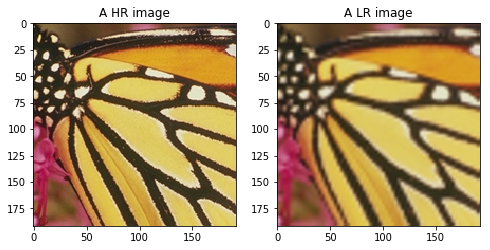

In [9]:
# Choose an image
ind = 5

HR_y = HR_test[ind,:,:,:]
HR_y = HR_y*255.0

HR_cb = HR_test_cb[ind,:,:,:]
HR_cr = HR_test_cr[ind,:,:,:]

HR_ex = np.concatenate((HR_y,HR_cb,HR_cr),axis=-1)
HR_ex = skimage.color.ycbcr2rgb(HR_ex)

LR_y = LR_test[ind,:,:,:]
LR_y = LR_y*255.0

LR_cb = LR_test_cb[ind,:,:,:]
LR_cr = LR_test_cr[ind,:,:,:]

LR_ex = np.concatenate((LR_y,LR_cb,LR_cr),axis=-1)
LR_ex = skimage.color.ycbcr2rgb(LR_ex)

plt.rcParams['figure.figsize']=(8,8)
plt.figure()
plt.subplot(121)
plt.imshow(HR_ex)
plt.title("A HR image")
plt.subplot(122)
plt.imshow(LR_ex)
plt.title("A LR image")
plt.show()

### 2. Buidling the U-Net model
#### 2.1. Define the parameters and the architecture

**Create a function ```model``` which**
- Give as input the image size
- parameters are used to modify the u-net model (e.g., ``weight_decay``, ``activation``) and the training strategy(e.g., ``lr_decay``,``percept_loss``)
- Define as internal parameters 
    - the number of kernels/feature channels per block. Usually they have increasing powers of 2. For instance, ```n_channels=[16,32,64,128,256]```
    - the kernel size 
    - the initializer (try `glorot_normal`)
- Create an input layer using the Keras function ``Input``
- Declare the encoder blocks composed of:
    - two convolutional layers (with the same number of input channels). Use ``Conv2D``.
    - one maxpool layer (except for the last block). Use ``MaxPooling2D``
    - use relu activations
    - **Hint** you may want to do this within a for loop to avoid errors in copy paste.
    - create a list with the encoder blocks to be able to point to them later.
- Define the decoder blocks composed of:
    - one Transpose convolution layer.
    - two convolutional layers. 
    - use relu activations
    - create a list with the encoder blocks to be able to point to them later.

- The output layer should be a Transpose convolution layer with a relu activation
- Create the skip connections 
    - connecting for each resolution the output of the encoder blocks to the input of the decoder blocks.

- Define the keras model with ``Model``


#### 2.1.1 Set options

In [10]:
# Define options for model
weight_decay = None        #regularizers.l2(0.01) or None, whether use weight decay or not
param_activ_func = 0       #0 for relu, 0.3 for leaky relu
res_block = True          # whether add residual block

# Options for training
init = 'RandNorm' # 'RandNorm' or 'GlorotNorm'
optim = 'Adam' # 'Adam' or 'SGD'
lr_decay = False           # whether use learning rate decay or not
lr_init = 0.001
percept_loss = False       # whether use perceptual loss or not

#### 2.1.2 Define U-net architecture

In [11]:
# Design our model architecture here
def unet_model(img_width=256, img_height=256):
    
    #define the architecture parameters
    n_channels = [16,32,64,128,256]  #the number of kernels/feature channels per block
    k_size = (3,3)                   #size of filter kernel
    k_init = RandomNormal(mean=0.0, stddev=0.001, seed=42) if init == 'RandNorm' else glorot_normal(seed=42)
    # RandomNormal is the initialization of SRCNN (Chao Dong et al.)
    
    # Use Keras Input layer to create one
    inp = Input((img_width, img_height,chan_num))
    
    # Encoder
    enc=[]
    
    for i in range(len(n_channels)):
        if i==0:
            pool=inp
        
        # Convolutional Layer #1
        conv1 = Conv2D(filters=n_channels[i], kernel_size=k_size, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init, kernel_regularizer=weight_decay)(pool)
        
        # Activation
        activ1 = Activation('relu')(conv1) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(conv1)
        
        # Convolutional Layer #2
        conv2 = Conv2D(filters=n_channels[i], kernel_size=k_size, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init, kernel_regularizer=weight_decay)(activ1)
        
        # Activation
        activ2 = Activation('relu')(conv2) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(conv2)
        
        #Add output of this block to the encoder blocks list
        enc.append(activ2)
        
        # Pooling Layer
        if i==len(n_channels)-1:
            pool = activ2
        else:
            pool = MaxPooling2D(pool_size=(2,2), strides=2, data_format="channels_last")(activ2)

    # Decoder
    dec=[enc[-1]]
    
    for i in range(len(n_channels)-2, -1, -1):
        # Transpose Convolutional Layer
        trans_conv = Conv2DTranspose(filters=n_channels[i], kernel_size=(2,2), strides=2, padding="same", data_format="channels_last",
                                     activation=None, kernel_initializer=k_init,kernel_regularizer=weight_decay)(dec[-1])
        
        # Concatenating
        conca = concatenate([enc[i],trans_conv])
        
        # Convolutional Layer #1
        conv1 = Conv2D(filters=n_channels[i], kernel_size=k_size, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init, kernel_regularizer=weight_decay)(conca)
        
        # Activation
        activ1 = Activation('relu')(conv1) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(conv1)
        
        # Convolutional Layer #2
        conv2 = Conv2D(filters=n_channels[i], kernel_size=k_size, padding="same", data_format="channels_last",
                       activation=None, kernel_initializer=k_init, kernel_regularizer=weight_decay)(activ1)
        
        # Activation
        activ2 = Activation('relu')(conv2) if param_activ_func == 0 else LeakyReLU(alpha = param_activ_func)(conv2)
        
        #Add output of this block to the decoder blocks list
        dec.append(activ2)

    # Output
    #outp = Conv2DTranspose(filters=chan_num, kernel_size=(2,2), strides=1, padding="same", data_format="channels_last",
                           #activation='relu', kernel_initializer=k_init,kernel_regularizer=weight_decay)(dec[-1])
    outp = Conv2D(filters=chan_num, kernel_size=k_size, strides=1, padding="same", data_format="channels_last",
                  activation='relu', kernel_initializer=k_init,kernel_regularizer=weight_decay)(dec[-1])
    
    # Residual block
    if res_block == True:
        outp = add([inp,outp])
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[outp])
    return model

#### 2.2. Define the losses and metrics

In [12]:
#MSE loss
def mse_loss(hr_img, sr_img):
    mse=K.mean(K.abs(hr_img-sr_img)**2)
    return mse

#Compute log10
def log10(x):
    numerator = K.log(x)
    denominator = K.log(K.constant(10, dtype=numerator.dtype))
    return numerator / denominator

#PSNR metric
def psnr(hr_img, sr_img):
    psnr = 20 * log10(1.0 / K.sqrt(mse_loss(hr_img, sr_img)))
    return psnr

#SSIM metric
def ssim(hr_img, sr_img):
    mu_h = K.mean(hr_img)
    mu_s = K.mean(sr_img)
    sig_h = K.std(hr_img)
    sig_s = K.std(sr_img)
    cov_hs = K.mean((hr_img-mu_h) * (sr_img-mu_s))
    
    c1 = 0.01**2
    c2 = 0.03**2
    
    ssim = (2*mu_h*mu_s + c1)*(2*cov_hs + c2)/(mu_h**2 + mu_s**2 + c1)/(sig_h**2 + sig_s**2 + c2)
    return ssim

#### 2.3 Define optimizer 

In [13]:
# Set some model compile parameters
optimizer = keras.optimizers.SGD(lr=lr_init,momentum=0.9) if optim == 'SGD' else keras.optimizers.Adam(lr=lr_init)
loss      = 'mean_squared_error'#mse_loss #"mean_absolute_error"
metrics   = [psnr,ssim] if weight_decay == None else [mse_loss,psnr,ssim]

#### 2.4 Compile the model

In [14]:
# Compile the model and list its structure
model = unet_model(img_width, img_height)
model.summary()
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 192, 192, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 192, 192, 16) 2320        activation_1[0][0]               
__________________________________________________________________________________________________
activation

#### 2.5. Define the perceptual loss

- If we want to use perceptual loss, ignore 2.2, 2.3, 2.4
- Instead of directly computing the loss between output images and the ground truth, we compute the loss between some features extracted from those two images.
- Here we use the pre-trained VGG-16 net to extract features.

In [12]:
# First let's make a main model (u-net model)
mainModel = unet_model(img_width, img_height)

# Then make a loss model (VGG-16 model)
from keras.applications.vgg16 import VGG16

lossModel = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width, img_height, 3))
lossModel.trainable=False

for layer in lossModel.layers:
    layer.trainable=False

# Select which layers' outputs will be used to compute loss
selectedLayers = ['block3_conv3']

#a list with the output tensors for each selected layer:
selectedOutputs = [lossModel.get_layer(name).output for name in selectedLayers]

#a new model with our chosen outputs:
lossModel = Model(lossModel.input,selectedOutputs) 

# VGG-16 requires 3-channel inputs
if chan_num == 1:
    vggInput = concatenate([mainModel.output,mainModel.output,mainModel.output])
else:
    vggInput = mainModel.output

# Connect mainModel.output with the lossModel
vggOutput = lossModel(vggInput)

# Create the full Model
fullModel = Model(inputs=mainModel.input, outputs=vggOutput)
fullModel.compile(loss='mse', optimizer='adam',metrics=['mse'])
fullModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 16) 160         input_7[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_55 (LeakyReLU)      (None, 256, 256, 16) 0           conv2d_55[0][0]                  
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 256, 256, 16) 2320        leaky_re_lu_55[0][0]             
__________________________________________________________________________________________________
leaky_re_l

### 3. Trainning

#### 3.1 Train with visualization of the losses

In [15]:
# Define save name
path1 = '_Factor' + str(SR_factor)
path2 = '_ResBlock_' if res_block == True else '_'
path3 = 'LRDecay' if lr_decay == True else 'LRFixed'
path4 = '_' + init
path5 = '_' + optim
path6 = '_' if weight_decay == None else '_WD_'
path7 = 'Relu' if param_activ_func == 0 else 'LeakyRelu'
path8 = '_PerceptLoss' if percept_loss == True else '_PixelLoss'

savename = path1 + path2 + path3 + path4 + path5 + path6 + path7 + path8

#### 3.1.1 Use self-defined functions to visualize training process

In [16]:
#4S
# Runtime custom callbacks for loss visualization
import matplotlib.pyplot as plt
from keras.callbacks import Callback
from IPython.display import clear_output
#from matplotlib.ticker import FormatStrFormatter

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Loss", 'psnr': "PSNR(dB)", 'ssim': "SSIM", 'mse_loss': "Loss"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.LR = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs.copy())
        self.LR.append(K.get_value(self.model.optimizer.lr))
        
        metric_dir = "./UNET_saved_model" + savename
        metric_path = 'metrics' + savename + '.svg'

        if not os.path.isdir(metric_dir):
            os.makedirs(metric_dir)

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        if weight_decay == None:
            for metric_id, metric in enumerate(self.base_metrics):
                plt.subplot(2, (len(self.base_metrics)+1)/2, metric_id + 1)
                plt.grid()

                plt.plot(range(1, len(self.logs) + 1),
                         [log[metric] for log in self.logs],
                         marker="o", label="training")
                if self.params['do_validation']:
                    plt.plot(range(1, len(self.logs) + 1),
                             [log['val_' + metric] for log in self.logs],
                             marker="o", label="validation")
                plt.title(translate_metric(metric))
                plt.xlabel('epoch')
                plt.legend(loc='center right')
            
            plt.subplot(2, (len(self.base_metrics)+1)/2, len(self.base_metrics)+1)
        else:
            for metric_id, metric in enumerate(self.base_metrics):
                if metric != 'loss':
                    plt.subplot(2, (len(self.base_metrics)+1)/2, metric_id)
                    plt.grid()

                    plt.plot(range(1, len(self.logs) + 1),
                             [log[metric] for log in self.logs],
                             marker="o", label="training")
                    if self.params['do_validation']:
                        plt.plot(range(1, len(self.logs) + 1),
                                 [log['val_' + metric] for log in self.logs],
                                 marker="o", label="validation")
                    plt.title(translate_metric(metric))
                    plt.xlabel('epoch')
                    plt.legend(loc='center right')
            
            plt.subplot(2, (len(self.base_metrics))/2, len(self.base_metrics))
              
        #plt.subplot(2, (len(self.base_metrics)+1)/2, len(self.base_metrics)+1)
        plt.grid()
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.plot(range(1, len(self.logs) + 1),self.LR,marker="o")
        plt.title('Learning rate')
        plt.xlabel('epoch')
        
        plt.tight_layout()
        plt.savefig(os.path.join(metric_dir, metric_path),format='svg', dpi=1200)
        plt.show();
        
plot_losses = PlotLosses(figsize=(12.8, 8))

#### 3.1.2 Use TensorBoard to visualize training process

In [20]:
# Create a folder to put log file
log_dir = "C:\\Users\\ruizhi\\Desktop\\internship\\u_net_SR\\callback_tensorboard"
#if not os.path.isdir(model_dir):
#    os.makedirs(log_dir)

# Create a Tensorboard Callback
tb = TensorBoard(log_dir=log_dir,histogram_freq=1,batch_size=8,write_images=True)

#### 3.2 Launch the training (pixel loss)
- Use the model.fit function, and  
- save the final model. 
- Measure the overall time.


#### 3.2.1 Training

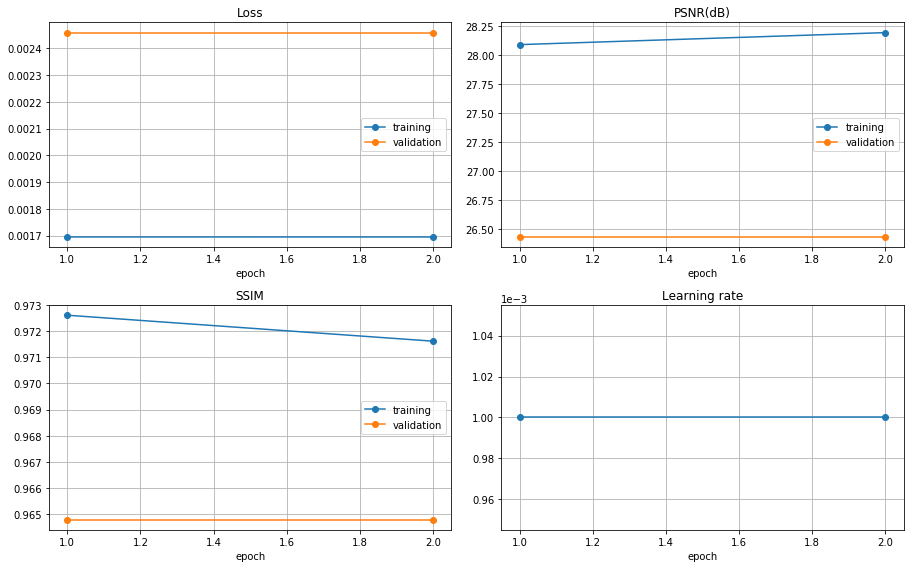


Epoch 00002: saving model to ./UNET_saved_model_Factor3_ResBlock_LRFixed_RandNorm_Adam_Relu_PixelLoss/models_on_epoch_end\model_Factor3_ResBlock_LRFixed_RandNorm_Adam_Relu_PixelLoss_02_0.0025.hdf5

Epoch 00002: saving model to ./UNET_saved_model_Factor3_ResBlock_LRFixed_RandNorm_Adam_Relu_PixelLoss/weights_on_epoch_end\weights_Factor3_ResBlock_LRFixed_RandNorm_Adam_Relu_PixelLoss_02_0.0025.h5
Wall time: 1min 37s


In [17]:
%%time

epochs=2
batch_size=8

plot_losses = PlotLosses(figsize=(12.8, 8))

# CheckPoint
model_dir = "./UNET_saved_model" + savename + "/models_on_epoch_end"
weight_dir = "./UNET_saved_model" + savename + "/weights_on_epoch_end"
model_path = 'model' + savename + '_{epoch:02d}' + '_{val_loss:.4f}' + '.hdf5'
weight_path = 'weights' + savename + '_{epoch:02d}' + '_{val_loss:.4f}' + '.h5'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)    
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

checkpoint1 = ModelCheckpoint(os.path.join(model_dir, model_path), monitor='val_loss', verbose=1, save_best_only=False,
                              save_weights_only=False, mode='min',period=2)
checkpoint2 = ModelCheckpoint(os.path.join(weight_dir, weight_path), monitor='val_loss', verbose=1, save_best_only=False,
                              save_weights_only=True, mode='min',period=2)

#Learning rate modifier
if lr_decay == True:
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.001)

    # Or modify learning rate by LearningRateScheduler
    def scheduler(epoch):
        # learning rate*0.1 every 10 epochs
        if epoch % 10 == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr * 0.1)
            print("lr changed to {}".format(lr * 0.1))
        return K.get_value(model.optimizer.lr)

    reduce_lr = LearningRateScheduler(scheduler)
    
    cb_list = [plot_losses,checkpoint1,checkpoint2,reduce_lr]
else:
    cb_list = [plot_losses,checkpoint1,checkpoint2]

# Fit
plt.ioff()
hist=model.fit(x=LR_train, y=HR_train, batch_size=batch_size, epochs=epochs,
               callbacks=cb_list, validation_data=(LR_valid,HR_valid))
plt.close('all')
plt.ion()

#### 3.2.2 Save the training history for further use

In [18]:
import pickle
# Save
hist_dir = "./UNET_saved_model" + savename
hist_path = 'TrainHistory' + savename

if not os.path.isdir(hist_dir):
    os.makedirs(hist_dir)    

with open(os.path.join(hist_dir, hist_path), 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

# Load (optional)
#with open('TrainHistory', 'rb') as file_pi:
#    hist_loaded = pickle.load(file_pi)

#### 3.2.3 Train with data augmentation

In [13]:
# Runtime data augmentation
def get_train_valid_augmented(X_data=LR_train, Y_data=HR_train, validation_split=0.1, batch_size=8, seed=seed):
    X_train, X_valid, Y_train, Y_valid = train_test_split(X_data,
                                                        Y_data,
                                                        train_size=1-validation_split,
                                                        test_size=validation_split,
                                                        random_state=seed)
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=90,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True, seed=seed)
    Y_datagen.fit(Y_train, augment=True, seed=seed)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True, seed=seed)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True, seed=seed)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_valid, augment=True, seed=seed)
    Y_datagen_val.fit(Y_valid, augment=True, seed=seed)
    X_valid_augmented = X_datagen_val.flow(X_valid, batch_size=batch_size, shuffle=True, seed=seed)
    Y_valid_augmented = Y_datagen_val.flow(Y_valid, batch_size=batch_size, shuffle=True, seed=seed)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    valid_generator = zip(X_valid_augmented, Y_valid_augmented)
    
    return train_generator, valid_generator

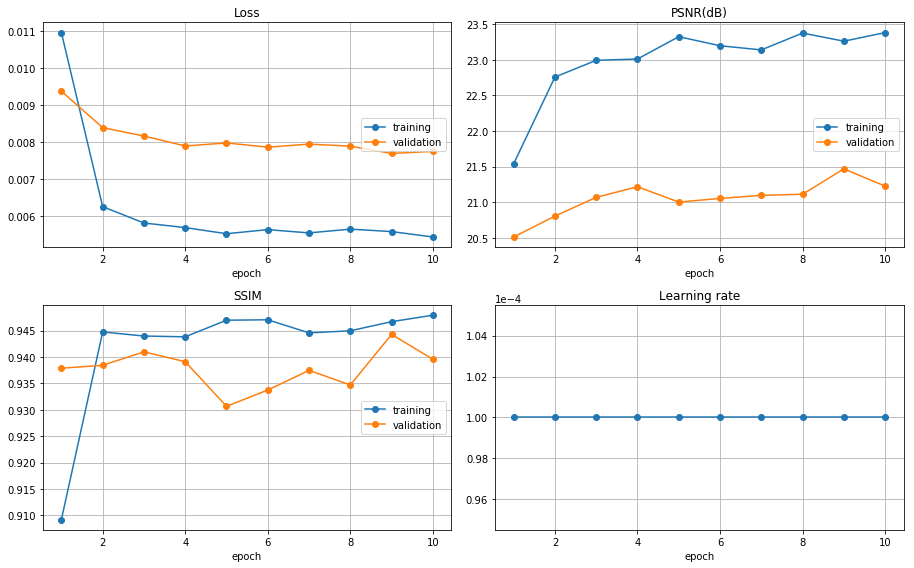


Epoch 00010: val_loss did not improve from 0.00769

Epoch 00010: val_loss did not improve from 0.00769
Wall time: 50min 8s


In [16]:
%%time

#Training with augmentation
epochs=10
batch_size=8

train_generator, valid_generator = get_train_valid_augmented(X_data=LR_train, Y_data=HR_train,
                                                           validation_split=0.1, batch_size=batch_size)

plot_losses = PlotLosses(figsize=(12.8, 8))

# CheckPoint
model_dir = "./UNET_saved_model" + savename + "/models_on_epoch_end"
weight_dir = "./UNET_saved_model" + savename + "/weights_on_epoch_end"
model_path = 'model' + savename + '_{epoch:02d}' + '_{val_loss:.4f}' + '.hdf5'
weight_path = 'weights' + savename + '_{epoch:02d}' + '_{val_loss:.4f}' + '.h5'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)    
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

checkpoint1 = ModelCheckpoint(os.path.join(model_dir, model_path), monitor='val_loss', verbose=1, save_best_only=False,
                              save_weights_only=False, mode='min',period=2)
checkpoint2 = ModelCheckpoint(os.path.join(weight_dir, weight_path), monitor='val_loss', verbose=1, save_best_only=False,
                              save_weights_only=True, mode='min',period=2)

#Learning rate modifier
if lr_decay == True:
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.001)

    # Or modify learning rate by LearningRateScheduler
    def scheduler(epoch):
        # learning rate*0.1 every 10 epochs
        if epoch % 10 == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr * 0.1)
            print("lr changed to {}".format(lr * 0.1))
        return K.get_value(model.optimizer.lr)

    reduce_lr = LearningRateScheduler(scheduler)
    
    cb_list = [plot_losses,checkpoint1,checkpoint2,reduce_lr]
else:
    cb_list = [plot_losses,checkpoint1,checkpoint2]

# Fit
validation_split = 0.1
steps_per_epoch = math.ceil(len(LR_train)*(1-validation_split)/batch_size)
validation_steps = math.ceil(len(LR_train)*validation_split/batch_size)

plt.ioff()
hist_augment = model.fit_generator(generator=train_generator, validation_data=valid_generator, 
                           validation_steps=validation_steps,
                    steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, callbacks=cb_list)
plt.close('all')
plt.ion()

#### 3.3 Launch the training (perceptual loss)
- Use the model.fit function, and  
- save the final model. 
- Measure the overall time.

In [1]:
%%time

epochs=1
batch_size=1

plot_losses = PlotLosses(figsize=(12.8, 8))

# CheckPoint
model_dir = "./UNET_saved_model" + savename + "/models_on_epoch_end"
weight_dir = "./UNET_saved_model" + savename + "/weights_on_epoch_end"
model_path = 'model' + savename + '_{epoch:02d}' + '_{val_loss:.4f}' + '.hdf5'
weight_path = 'weights' + savename + '_{epoch:02d}' + '_{val_loss:.4f}' + '.h5'

if not os.path.isdir(model_dir):
    os.makedirs(model_dir)    
if not os.path.isdir(weight_dir):
    os.makedirs(weight_dir)

checkpoint1 = ModelCheckpoint(os.path.join(model_dir, model_path), monitor='val_loss', verbose=1, save_best_only=False,
                              save_weights_only=False, mode='min',period=2)
checkpoint2 = ModelCheckpoint(os.path.join(weight_dir, weight_path), monitor='val_loss', verbose=1, save_best_only=False,
                              save_weights_only=True, mode='min',period=2)

#Learning rate modifier
if lr_decay == True:
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min')

    # Or modify learning rate by LearningRateScheduler
    def scheduler(epoch):
        # learning rate*0.1 every 5 epochs
        if epoch % 10 == 0 and epoch != 0:
            lr = K.get_value(model.optimizer.lr)
            K.set_value(model.optimizer.lr, lr * 0.1)
            print("lr changed to {}".format(lr * 0.1))
        return K.get_value(model.optimizer.lr)

    reduce_lr = LearningRateScheduler(scheduler)
    cb_list = [plot_losses,checkpoint1,checkpoint2,reduce_lr]
else:
    cb_list = [plot_losses,checkpoint1,checkpoint2]

# Put HR images to the loss model to generate corresponding feature ground truth
if chan_num == 1:
    triple_HR_train = np.concatenate((HR_train,HR_train,HR_train),axis=-1)
    #triple_HR_valid = np.concatenate((HR_valid,HR_valid,HR_valid),axis=-1)
else:
    triple_HR_train = HR_train
    #triple_HR_valid = HR_valid

HR_train_percept = lossModel.predict(triple_HR_train)
#HR_valid_percept = lossModel.predict(triple_HR_valid)
print(HR_train_percept.shape)
#print(HR_valid_percept.shape)

# Fit
plt.ioff()
hist_percept=fullModel.fit(x=LR_train, y=HR_train_percept, batch_size=batch_size, epochs=epochs,
                           callbacks=cb_list, validation_split=0.1)#validation_data=(LR_valid,HR_valid_percept))
plt.close('all')
plt.ion()

NameError: name 'PlotLosses' is not defined

### 4. Test phase

#### 4.1 Define functions for computing metrics and plotting figures

In [22]:
def compute_psnr(hr_img, sr_img):
    mse=np.mean(abs(sr_img-hr_img)**2)
    psnr = 20 * math.log10(1.0 / math.sqrt(mse))
    return psnr

def compute_ssim(hr_img, sr_img):
    mu_h = np.mean(hr_img)
    mu_s = np.mean(sr_img)
    sig_h = np.std(hr_img)
    sig_s = np.std(sr_img)
    cov_hs = np.mean((hr_img-mu_h) * (sr_img-mu_s))
    
    c1 = 0.01**2
    c2 = 0.03**2
    
    ssim = (2*mu_h*mu_s + c1)*(2*cov_hs + c2)/(mu_h**2 + mu_s**2 + c1)/(sig_h**2 + sig_s**2 + c2)
    return ssim

def compute_psnr_ssim(SR_test_array):
    psnr_bi=[]
    psnr_sr=[]
    ssim_bi=[]
    ssim_sr=[]

    for i in range(SR_test_array.shape[0]):
        psnr_bi.append(compute_psnr(HR_test[i,:,:,:],LR_test[i,:,:,:]))
        psnr_sr.append(compute_psnr(HR_test[i,:,:,:],SR_test_array[i,:,:,:]))
        ssim_bi.append(compute_ssim(HR_test[i,:,:,:],LR_test[i,:,:,:]))
        ssim_sr.append(compute_ssim(HR_test[i,:,:,:],SR_test_array[i,:,:,:]))

    psnr_bi.append(np.mean(psnr_bi))
    psnr_sr.append(np.mean(psnr_sr))
    ssim_bi.append(np.mean(ssim_bi))
    ssim_sr.append(np.mean(ssim_sr))

    print('bicubic average psnr on test set:',psnr_bi[-1],'dB')
    print('SR average on test set:',psnr_sr[-1],'dB')
    print('bicubic average ssim on test set:',ssim_bi[-1])
    print('SR average on test set:',ssim_sr[-1])

    dict_psnr_ssim = {"bic_psnr":psnr_bi, "sr_psnr":psnr_sr, "bic_ssim":ssim_bi, "sr_ssim":ssim_sr}
    return dict_psnr_ssim

def draw(SR_test,img_index,epoch_index):

    HR_y = HR_test[img_index,:,:,:]
    HR_y = HR_y*255.0

    HR_cb = HR_test_cb[img_index,:,:,:]
    HR_cr = HR_test_cr[img_index,:,:,:]

    HR_ex = np.concatenate((HR_y,HR_cb,HR_cr),axis=-1)
    HR_ex = skimage.color.ycbcr2rgb(HR_ex)

    LR_y = LR_test[img_index,:,:,:]
    LR_y = LR_y*255.0

    LR_cb = LR_test_cb[img_index,:,:,:]
    LR_cr = LR_test_cr[img_index,:,:,:]

    LR_ex = np.concatenate((LR_y,LR_cb,LR_cr),axis=-1)
    LR_ex = skimage.color.ycbcr2rgb(LR_ex)

    SR_y = SR_test[img_index,:,:,:]
    SR_y = SR_y*255.0

    SR_ex = np.concatenate((SR_y,LR_cb,LR_cr),axis=-1)
    SR_ex = skimage.color.ycbcr2rgb(SR_ex)

    result_dir = "./UNET_saved_model" + loadname + "/test_imshow"
    result_path = 'test_image' + loadname + "_epoch" + str(2*epoch_index+2) + '.svg'

    if not os.path.isdir(result_dir):
        os.makedirs(result_dir)

    plt.rcParams['figure.figsize']=(12.8,12.8)
    plt.figure()
    plt.subplot(131)
    plt.imshow(LR_ex,cmap='gray')
    plt.title("Input(bicubic)/{0:.2f}dB/{1:.4f}".format(dict_psnr_ssim['bic_psnr'][img_index],dict_psnr_ssim['bic_ssim'][img_index]))
    plt.subplot(132)
    plt.imshow(SR_ex,cmap='gray')
    plt.title("SR result/{0:.2f}dB/{1:.4f}".format(dict_psnr_ssim['sr_psnr'][img_index],dict_psnr_ssim['sr_ssim'][img_index]))
    plt.subplot(133)
    plt.imshow(HR_ex,cmap='gray')
    plt.title("Ground truth/PSNR/SSIM")
    plt.savefig(os.path.join(result_dir, result_path), format='svg',dpi=1200)
    plt.show()

#### 4.2 Reload the model and test
- Reload the keras model and fill it with the saved weights ``model_loaded.load_weights``
- Do prediction on the test set
- Compute PSNR and SSIM
- Visualize qualitative results
- Save both quantitive and qualitative results

In [23]:
# Select which model to load
path1 = '_Factor' + str(SR_factor)
path2 = '_ResBlock_' if res_block == True else '_'
path3 = 'LRDecay' if lr_decay == True else 'LRFixed'
path4 = '_' + init
path5 = '_' + optim
path6 = '_' if weight_decay == None else '_WD_'
path7 = 'Relu' if param_activ_func == 0 else 'LeakyRelu'
path8 = '_PerceptLoss' if percept_loss == True else '_PixelLoss'

loadname = path1 + path2 + path3 + path4 + path5 + path6 + path7 + path8
load_dir = "./UNET_saved_model" + loadname + "/weights_on_epoch_end"

8/8 [==============================] - 2s 196ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 192, 192, 1) float32
bicubic average psnr on test set: 31.243475026258352 dB
SR average on test set: 31.243475019218508 dB
bicubic average ssim on test set: 0.9843602658330683
SR average on test set: 0.9843602796583679


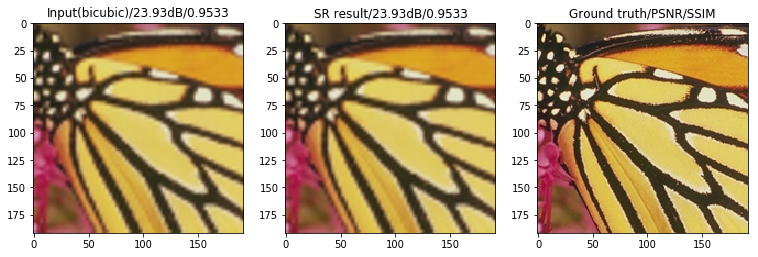

8/8 [==============================] - 2s 211ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(8, 192, 192, 1) float32
bicubic average psnr on test set: 31.243475026258352 dB
SR average on test set: 31.243475019218508 dB
bicubic average ssim on test set: 0.9843602658330683
SR average on test set: 0.9843602796583679


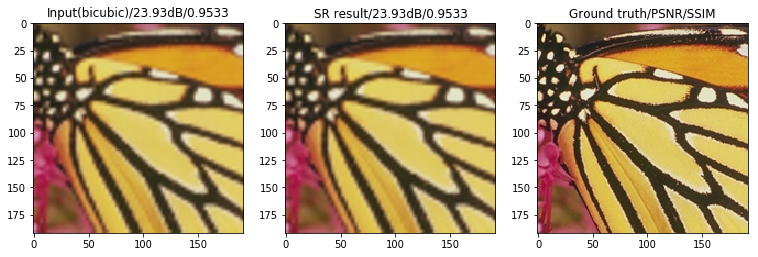

In [24]:
# load models and predict
load_paths = ['{0}/{1}'.format(load_dir, id) for id in os.listdir(load_dir)]

for ind,path in enumerate(load_paths):
    model_loaded = unet_model(img_width=img_width, img_height=img_height)
    model_loaded.load_weights(path)
    model_loaded.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    SR_test = model_loaded.predict(LR_test, verbose=1)
    print(SR_test.shape, SR_test.dtype)
    
    dict_psnr_ssim = compute_psnr_ssim(SR_test)
    
    dict_dir = "./UNET_saved_model" + loadname + "/test_PSNR_list"
    dict_path = "PSNRlist" + loadname + "_epoch" + str(2*ind+2)
    
    if not os.path.isdir(dict_dir):
        os.makedirs(dict_dir)

    with open(os.path.join(dict_dir, dict_path), 'wb') as file_pi:
        pickle.dump(dict_psnr_ssim, file_pi)
    
    draw(SR_test,5,ind)

### 5. Compare validation loss of different models

In [7]:
# Load history files
import pickle
with open('TrainHistory_Factor2_Relu_PixelLoss_LRFixed_', 'rb') as file_pi:
    hist_loaded = pickle.load(file_pi)
loss_base=hist_loaded['val_loss']

with open('TrainHistory_Factor2_LeakyRelu_PixelLoss_LRFixed_ResBlock', 'rb') as file_pi:
    hist_loaded = pickle.load(file_pi)
loss_leaky=hist_loaded['val_loss']

with open('TrainHistory_Factor2_Relu_PixelLoss_LRDecay1e-4_ResBlock', 'rb') as file_pi:
    hist_loaded = pickle.load(file_pi)
loss_lrdecay=hist_loaded['val_loss']

with open('TrainHistory_Factor2_Relu_PixelLoss_LRFixed1e-4_ResBlock', 'rb') as file_pi:
    hist_loaded = pickle.load(file_pi)
loss_res=hist_loaded['val_loss']

with open('TrainHistory_Factor2_WD_Relu_PixelLoss_LRFixed_ResBlock', 'rb') as file_pi:
    hist_loaded = pickle.load(file_pi)
loss_wd=hist_loaded['val_mse_loss']

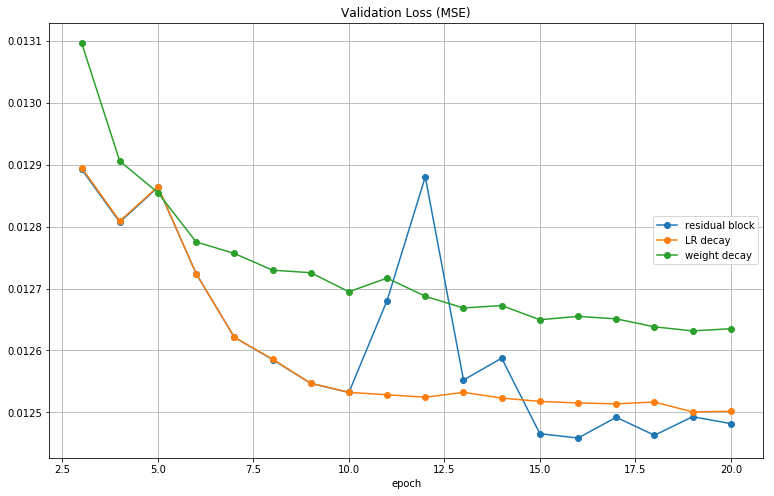

In [13]:
# Plot
plt.figure(figsize=(12.8,8))
plt.grid()
#plt.plot(range(3, len(loss_base) + 1),loss_base[2:20],marker="o", label="basic model")
plt.plot(range(3, len(loss_res) + 1),loss_res[2:20],marker="o", label="residual block")
plt.plot(range(3, len(loss_lrdecay) + 1),loss_lrdecay[2:20],marker="o", label="LR decay")
#plt.plot(range(3, len(loss_leaky) + 1),loss_leaky[2:20],marker="o", label="leaky relu")
plt.plot(range(3, len(loss_wd) + 1),loss_wd[2:20],marker="o", label="weight decay")
plt.title('Validation Loss (MSE)')
plt.xlabel('epoch')
plt.legend(loc='center right')
plt.savefig('valid_loss2.svg',format='svg', dpi=1200)
plt.show()